<a href="https://colab.research.google.com/github/muhammadmo/covid-19-detection/blob/main/IOT_framework_(CXR_data_%2B_InceptionResNetV2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadmoosavi","key":"1fa1bc8aae4bfd517b860f44615ff8d9"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sachinkumar413/covid-pneumonia-normal-chest-xray-images

 96% 265M/277M [00:02<00:00, 164MB/s]
100% 277M/277M [00:02<00:00, 138MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "covid-pneumonia-normal-chest-xray-images.zip"

with ZipFile(file_name,'r') as zipp:
  zipp.extractall()
print('done')

done


In [ ]:
pip install split_folders

In [ ]:
import splitfolders
input_folder = "/content/dataset"
output = "/content/splited_dataset"

splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.7, .1, .2))

Copying files: 5228 files [00:01, 3096.16 files/s]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

train_path = '/content/splited_dataset/train'
test_path = '/content/splited_dataset/test'
valid_path = '/content/splited_dataset/val'

#set defult image size
batch_size = 16
img_width = 229
img_height = 229
#img_channel = 3

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                rotation_range=15,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                rescale = 1./255,
                                shear_range = 0.2,
                                zoom_range = 0.2,
                                horizontal_flip = True,
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      shuffle=False,
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem
      class_mode='sparse',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='rgb',
      class_mode='sparse',
      batch_size=batch_size
      )


Found 3659 images belonging to 3 classes.
Found 1047 images belonging to 3 classes.
Found 522 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import InceptionResNetV2

conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(229, 229, 3))

conv_base.summary()

219070464/219055592 [==============================] - 2s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 229, 229, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_285 (Conv2D)            (None, 114, 114, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_282 (Batch  (None, 114, 114, 32  96         ['conv2d_285[0][0]']             
 Normalizatio

In [ ]:
from keras import models
from keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop

optimizer = keras.optimizers.Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)

model = models.Sequential()

model.add(Conv2D(3, (3, 3), padding="same", activation="relu", input_shape=(img_width, img_height, 1)))

model.add(conv_base)

model.add(GlobalAveragePooling2D())

model.add(layers.Flatten())
#model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
#model.add(layers.BatchNormalization())

#model.add(layers.Dense(4096, activation='relu'))
#model.add(Dense(activation = 'relu', units = 64))
model.add(Dense(3,activation="softmax"))
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
#model.compile(optimizer = RMSprop(lr=1e-2) , loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

conv_base.trainable = False
#fine-tuning
'''
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False
'''
model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_489 (Conv2D)         (None, 229, 229, 3)       30        
                                                                 
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 global_average_pooling2d_4   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_5 (Flatten)         (None, 1536)              0         
                                                                 
 dropout_10 (Dropout)        (None, 1536)              0         
                                                                 
 dense_14 (Dense)            (None, 1024)             

In [ ]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

#early stopping
early = EarlyStopping(monitor="val_loss",
                      mode="auto",
                      patience=9)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 4, verbose=1,factor=1e-1, min_lr=0.000001)

checkpoint_filepath = 'checkpointCNN4.h5'
Model_check = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

checkpoint_filepath1 = 'checkpointCNN5.h5'
Model_check1 = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath1, monitor='val_loss', verbose=1, save_best_only=False, mode='auto')

callbacks_list = [ early, learning_rate_reduction]

In [ ]:
history = model.fit(train,
                    batch_size=16,
                    epochs=30,
                    validation_data=valid,
                    callbacks=[early,learning_rate_reduction, Model_check, Model_check1])

Epoch 1/30
229/229 [==============================] - ETA: 0s - loss: 0.9937 - accuracy: 0.6067
Epoch 1: val_loss improved from inf to 0.32235, saving model to checkpointCNN4.h5

Epoch 1: saving model to checkpointCNN5.h5
229/229 [==============================] - 216s 884ms/step - loss: 0.9937 - accuracy: 0.6067 - val_loss: 0.3223 - val_accuracy: 0.9195 - lr: 0.0030
Epoch 2/30
229/229 [==============================] - ETA: 0s - loss: 0.2100 - accuracy: 0.9317
Epoch 2: val_loss improved from 0.32235 to 0.15758, saving model to checkpointCNN4.h5

Epoch 2: saving model to checkpointCNN5.h5
229/229 [==============================] - 198s 864ms/step - loss: 0.2100 - accuracy: 0.9317 - val_loss: 0.1576 - val_accuracy: 0.9464 - lr: 0.0030
Epoch 3/30
229/229 [==============================] - ETA: 0s - loss: 0.1212 - accuracy: 0.9568
Epoch 3: val_loss improved from 0.15758 to 0.15505, saving model to checkpointCNN4.h5

Epoch 3: saving model to checkpointCNN5.h5
229/229 [=====================

In [ ]:
from keras.models import load_model
model = load_model('checkpointCNN4.h5')
test_accu = model.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

66/66 [==============================] - 25s 318ms/step - loss: 0.1688 - accuracy: 0.9618
The testing accuracy is : 96.17956280708313 %


In [ ]:
import numpy as np
rounded_labels=np.argmax(preds, axis=1)
rounded_labels[1]

0

In [ ]:
from sklearn.metrics import confusion_matrix
cmm = confusion_matrix(rounded_labels, test.classes)
cmm

array([[322,   0,   1],
       [  2, 361,  37],
       [  2,   0, 322]])

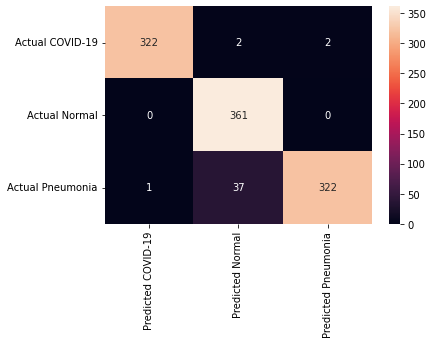

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, rounded_labels, labels=[0, 1, 2]),index=["Actual COVID-19", "Actual Normal", "Actual Pneumonia"],
columns=["Predicted COVID-19", "Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes,y_pred=rounded_labels,target_names =['COVID-19','NORMAL','Pneumonia']))

              precision    recall  f1-score   support

    COVID-19       1.00      0.99      0.99       326
      NORMAL       0.90      1.00      0.95       361
   Pneumonia       0.99      0.89      0.94       360

    accuracy                           0.96      1047
   macro avg       0.96      0.96      0.96      1047
weighted avg       0.96      0.96      0.96      1047

